In [1]:
from sentinelsat import SentinelAPI # for downloading data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask

import json
# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

user = credentials['SENTINEL_USER']
password = credentials['SENTINEL_PASSWORD']
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
nyc_geo = gpd.read_file('manhattan/POLYGON.shp')

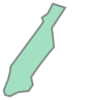

In [5]:
nyc_geo['geometry'].values[0]

In [ ]:
m = folium.Map([40.730610, -73.935242], zoom_start=10) # New York City


In [ ]:
folium.GeoJson(nyc_geo).add_to(m)
# visualize the map
m

In [ ]:
footprint = None
for i in nyc_geo['geometry']:
    footprint = i

In [ ]:
products = api.query(footprint,
                     date = ('20220101', '20220901'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [ ]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted.shape

In [ ]:
downloaded_image = api.download(products_gdf.index[0])

In [ ]:
downloaded_image['path']

In [ ]:
import zipfile
 
zip_file = downloaded_image['path']

try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

In [ ]:
imagery_folders = [x for x in os.listdir() if x.endswith('SAFE')]

In [ ]:
for imagery in imagery_folders:
    l2a_folder = os.listdir(f'{imagery}/GRANULE')[0]
    r10_path = f"{imagery}/GRANULE/{l2a_folder}/IMG_DATA/R10m"
    for band in os.listdir(r10_path):
    # extract bands 2,3, and 4 from r10:

        if 'B02' in band:
            b2 = rio.open(f"{r10_path}/{band}")
        elif 'B03' in band:
            b3 = rio.open(f"{r10_path}/{band}")
        elif 'B04' in band:
            b4 = rio.open(f"{r10_path}/{band}")

In [ ]:

band2_img = b2.read(1)
band3_img = b3.read(1)
band4_img = b4.read(1)

In [ ]:
plt.imshow(band4_img[:4000,:4000])

In [ ]:
# this will take a while on the Nano..
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

In [2]:
from rasterio import mask

In [8]:
import rasterio

In [13]:

with rio.open("RGB.tiff") as src:
    out_meta = src.meta.copy()
    nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
    out_image, out_transform = mask.mask(src, nyc_geo_projected.geometry,crop=True) #TODO: note that projected has to be in the geo from out_meta. 
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    



/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
with rasterio.open("RGB_masked.tiff", "w", **out_meta) as dest:
    dest.write(out_image)

In [25]:
src = rio.open("RGB_masked.tiff")


In [40]:
img = src.read()

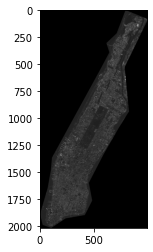

In [45]:
plt.imshow(img[0],cmap='gray')

In [ ]:
# TODO next downloaded image can be metadata and use that as part of filename when saved down (then all else gets deleted)

In [ ]:
import rasterio

In [ ]:
rasterio.features.bounds(nyc_geo_projected.geometry)

In [ ]:
%debug

In [ ]:
#geometry is the rater